In [1]:
!pip install tensorflow__text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 7.4 MB/s 
     |████████████████████████████████| 511.7 MB 5.8 kB/s 
     |████████████████████████████████| 1.6 MB 48.1 MB/s 
     |████████████████████████████████| 5.8 MB 37.0 MB/s 
     |████████████████████████████████| 438 kB 67.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninst

BERT tutorial: Classify spam vs no spam emails

In [41]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/codebasics/deep-learning-keras-tf-tutorial/master/47_BERT_text_classification/spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [8]:
747/4825

0.15481865284974095

15% spam emails, 85% ham emails: This indicates class imbalance

In [9]:
df_spam = df[df['Category'] == 'spam']
df_ham = df[df['Category'] == 'ham']

In [10]:
df_ham_down = df_ham.sample(df_spam.shape[0])

In [11]:
df_spam.shape, df_ham_down.shape

((747, 2), (747, 2))

In [12]:
df_balanced = pd.concat([df_spam, df_ham_down])
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [13]:
df_balanced['Spam'] = df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,Spam
3130,ham,"Haha better late than ever, any way I could sw...",0
1227,spam,Reply with your name and address and YOU WILL ...,1
5068,spam,83039 62735=£450 UK Break AccommodationVoucher...,1
3092,spam,LORD OF THE RINGS:RETURN OF THE KING in store ...,1
5081,ham,"Keep ur problems in ur heart, b'coz nobody wil...",0


Split the data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['Spam'], test_size=0.2, stratify=df_balanced['Spam'])

In [16]:
X_train.shape, X_test.shape, y_train.shape

((1195,), (299,), (1195,))

Now lets import BERT model and get embeding vectors for few sample statements

In [17]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [18]:
def get_sentence_embedding(sentence):
  preprocessed_text = bert_preprocess(sentence)
  return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embedding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351724, -0.51327276, -0.88845724, ..., -0.74748844,
        -0.7531474 ,  0.91964495],
       [-0.87208337, -0.5054394 , -0.94446665, ..., -0.85847497,
        -0.71745324,  0.8808295 ]], dtype=float32)>

Get embeding vectors for few sample words. Compare them using cosine similarity

In [21]:
e = get_sentence_embedding([
    'banana',
    'grapes',
    'mango',
    'jeff bezos',
    'elon musk',
    'bill'
])

In [22]:
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

In [23]:
cosine_similarity([e[0]],[e[2]])

array([[0.99540985]], dtype=float32)

In [24]:
cosine_similarity([e[1]],[e[3]])

array([[0.87739706]], dtype=float32)

In [25]:
cosine_similarity([e[3]],[e[5]])

array([[0.79592586]], dtype=float32)

Build model

There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f76605

In [27]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
outputs = get_sentence_embedding(text_input)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs)
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

# Construct final model using inputs and outputs
model = tf.keras.Model(inputs=[text_input], outputs=[l])


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [29]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)

In [30]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
38/38 [==============================] - 21s 317ms/step - loss: 0.6142 - accuracy: 0.6870 - precision: 0.6874 - recall: 0.6851
Epoch 2/10
38/38 [==============================] - 12s 316ms/step - loss: 0.4961 - accuracy: 0.8142 - precision: 0.8019 - recall: 0.8342
Epoch 3/10
38/38 [==============================] - 12s 319ms/step - loss: 0.4139 - accuracy: 0.8762 - precision: 0.8639 - recall: 0.8928
Epoch 4/10
38/38 [==============================] - 12s 324ms/step - loss: 0.3665 - accuracy: 0.8895 - precision: 0.8869 - recall: 0.8928
Epoch 5/10
38/38 [==============================] - 13s 332ms/step - loss: 0.3362 - accuracy: 0.8954 - precision: 0.8907 - recall: 0.9012
Epoch 6/10
38/38 [==============================] - 13s 338ms/step - loss: 0.3224 - accuracy: 0.8929 - precision: 0.8813 - recall: 0.9079
Epoch 7/10
38/38 [==============================] - 13s 340ms/step - loss: 0.2971 - accuracy: 0.9079 - precision: 0.8959 - recall: 0.9229
Epoch 8/10
38/38 [================

In [31]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 4s 307ms/step - loss: 0.2758 - accuracy: 0.9197 - precision: 0.9437 - recall: 0.8933


[0.27582448720932007,
 0.9197324514389038,
 0.9436619877815247,
 0.8933333158493042]

In [32]:
y_predicted = model.predict(X_test)

10/10 [==============================] - 4s 329ms/step


In [ ]:
y_predicted = y_predicted.flatten()

In [37]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1])

In [43]:
cm = confusion_matrix(y_test, y_predicted)
cm

array([[141,   8],
       [ 16, 134]])

Text(33.0, 0.5, 'Truth')

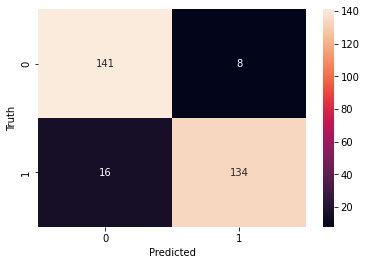

In [44]:
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [45]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       149
           1       0.94      0.89      0.92       150

    accuracy                           0.92       299
   macro avg       0.92      0.92      0.92       299
weighted avg       0.92      0.92      0.92       299



Inference

In [46]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 1s 767ms/step


array([[0.6441855 ],
       [0.74818414],
       [0.67549527],
       [0.11631382],
       [0.0659105 ]], dtype=float32)